# Tool to visualize a fish segmentation and choose different morpholical parameters

This notebook is a short demo of the different information you can extract from the trait segmentation.
it is similar than a tutorial that allows you to understand the data step by step
Please comment as much as you want...

In [65]:
# import the differente library
import os
import sys
import numpy as np
from PIL import Image
from skimage.measure import label, regionprops, regionprops_table
from math import sqrt
import json
import matplotlib.pyplot as plt
import pprint

## Import and convert the segmentation png into 12 channels

In [2]:
# Create dictionnary to convert between trait category and channels and color

trait_list = ["background", "dorsal_fin", "adipos_fin", "caudal_fin", "anal_fin", "pelvic_fin", "pectoral_fin",
              "head", "eye", "caudal_fin_ray", "alt_fin_ray", "alt_fine_spine", "trunk"]

color_list = [np.array([0, 0, 0]), np.array([254, 0, 0]),
              np.array([0, 254, 0]), np.array([0, 0, 254]),
              np.array([254, 254, 0]), np.array([0, 254, 254]),
              np.array([254, 0, 254]), np.array([254, 254, 254]),
              np.array([0, 254, 102]), np.array([254, 102, 102]),
              np.array([254, 102, 204]), np.array([254, 204, 102]),
              np.array([0, 124, 124])]

# Create dictionnaries to go from channel to color or from trait to color
channel_color_dict = {i: j for i, j in enumerate(color_list)}
trait_color_dict = dict(zip(trait_list, color_list))


In [3]:
# choose the different file
image_path = 'INHS_122505_segmented.png'
metadata_file = 'INHS_122505.json'

In [4]:
def import_segmented_image(image_path):
    '''
    import the image from "image_path" and convert to np.array astype uint8 (0-255)

    '''
    img = Image.open(image_path)
    img_arr = np.array(img, dtype=np.uint8)

    return img_arr

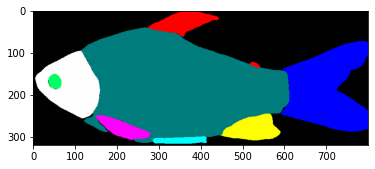

In [16]:
# import the image into array
img = import_segmented_image(image_path)
plt.imshow(img)

In [6]:
def get_one_trait_mask(img, trait_color_dict, trait_key):
    '''
    Create a mask for a trait define by "trait_key" using "img" (the image array)
    and trait_color_dict (the trait to color dictionnary) 

    '''
    color_array = trait_color_dict[trait_key]
    trait_mask = (img[:, :, 0] == color_array[0]) & (
        img[:, :, 1] == color_array[1]) & (img[:, :, 2] == color_array[2])

    return trait_mask

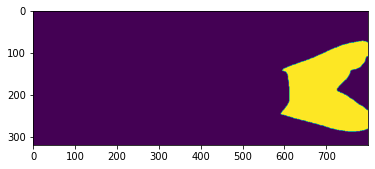

In [8]:
trait_mask = get_one_trait_mask(img, trait_color_dict, "caudal_fin")
plt.imshow(trait_mask)

In [9]:

def get_channels_mask(img, trait_color_dict):
    ''' Convert the png image (numpy.ndarray, np.uint8)  (320, 800, 3)
    to a mask_channel (320, 800, 12) Binary map

    input
    output
    img shape -> (320, 800, 3) if normal=True
    else: mask shape -> (12, 320, 800)
        we want to output a PIL image with rgb color value
    '''

    mask = {}
    for color, trait in enumerate(trait_color_dict):

        mask[trait] = get_one_trait_mask(
            img, trait_color_dict, trait).astype("uint8")

    return mask

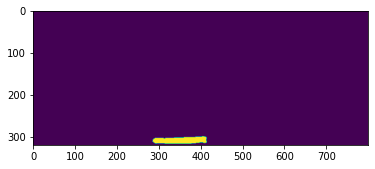

In [15]:
mask = get_channels_mask(img, trait_color_dict)
plt.imshow(mask["pelvic_fin"])

In [17]:
def get_scale(metadata_file):

    f = open(metadata_file)
    data = json.load(f)
    first_value = list(data.values())[0]

    if first_value['has_ruler']==True:

        scale = round(first_value['scale'],3)
    else: scale =[None]
    
    return scale

In [20]:
scale_value = get_scale(metadata_file)
scale_value

283.14

In [51]:
def get_morphology_one_trait(trait_key, mask, parameter=None):

    trait_mask = mask[trait_key]
    total_area = sum(sum(trait_mask))
    label_trait = label(trait_mask)
    regions_trait = regionprops(label_trait)
    
    result={"area":[], "percent" : [],"centroid":[], "bbox":[]}
    # iterate throught the region sorted by area size
    # if there are several blobs, it will create a list in each properties
    # for each blob i.e result["area"] =[area_1, area_2...]
    for region in sorted(regions_trait, key=lambda r: r.area, reverse=True):

        # choose what you want to see 
        result["area"].append(region.area)
        result["percent"].append(region.area/total_area)
        result["centroid"].append(region.centroid)
        result["bbox"].append(region.bbox)
    
    return result, regions_trait

In [56]:
# test regions_trait objec
res_head, head = get_morphology_one_trait("head", mask)

# you can extract any sort of morphological parameters 
# you can check the format of each on the output there:
# https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
centroid_head = list(head[0].centroid) # list() convert tuple to list
area_head = head[0].area
bbox_head = list(head[0].bbox) # list() convert tuple to list

print(centroid_head)
print(area_head)
print(bbox_head)

[176.31740636642917, 92.29099941172626]
15299
[94, 5, 257, 160]


In [45]:
# for development only
def vizualize_trait_bbox (img, regions_trait):

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    # plot bounding box
    min_y, min_x, max_y, max_x = regions_trait[0].bbox
    bx = (min_x, max_x, max_x, min_x,min_x)
    by = (min_y, min_y, max_y, max_y, min_y )
    ax.plot(bx, by, '-b', linewidth=2.5)
    
    # bottom of the bbox
    bx =  (max_x, min_x)
    by =  (max_y, max_y)
    ax.plot(bx, by, '-r', linewidth=1)
    
    # left of the bbox
    bx =  (min_x, min_x)
    by =  (max_y, min_y)
    ax.plot(bx, by, '-w', linewidth=1)
    
    # plot centroid
    x0, y0 = regions_trait[0].centroid
    ax.plot(y0, x0, '.g', markersize=10)
    
    


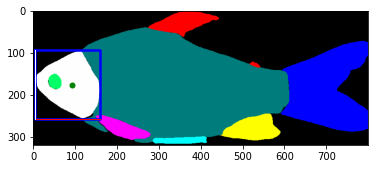

In [46]:
head_trait = get_morphology_one_trait("head", mask)
vizualize_trait_bbox (img, head_trait)


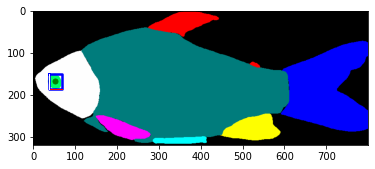

In [47]:
eye_trait = get_morphology_one_trait("eye", mask)
vizualize_trait_bbox (img, eye_trait)

In [59]:
# this function should be used as template
# it takes the output of get_morphology_one_trait
def compare_head_eye(result_head, head, result_eye, eye, metadata_file,  name=None):
    
    # Checked if there is a major big blob
    if result_head["percent"][0] > 0.85 and result_eye["percent"][0] > 0.85:

        head = head[0]
        eye = eye[0]
        ratio_eye_head = eye.area/(head.area + eye.area)

        coord_head = head.centroid
        coord_eye = eye.centroid

        distance_eye_snout =  abs(head.bbox[1]-eye.bbox[1])
        scale = get_scale(metadata_file)
        
    return {name:{"eye_head_ratio" : round(ratio_eye_head,3),
                "snout_eye_distance": round(distance_eye_snout,3), "scale":scale}}

In [71]:
result_head, head = get_morphology_one_trait("head", mask)
result_eye, eye = get_morphology_one_trait("eye", mask)
result  = compare_head_eye(result_head, head, result_eye, eye, metadata_file,  
                           name="fish_name")
pprint.pprint(result)

{'fish_name': {'eye_head_ratio': 0.055,
               'scale': 283.14,
               'snout_eye_distance': 32}}
